In [15]:
import re
import math
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [16]:
df = pd.read_csv("FIFA17_official_data_cleaned.csv")

In [20]:
df.shape

(17317, 63)

In [17]:
num_df = df.select_dtypes(include='number')
num_col = num_df.columns.tolist()
print(num_col)

cat_df = df.select_dtypes(include='object')
cat_col = cat_df.columns.tolist()
print(cat_col)

['ID', 'Age', 'Overall', 'Potential', 'Value', 'Wage', 'Special', 'International Reputation', 'Weak Foot', 'Skill Moves', 'Jersey Number', 'Joined', 'Contract Valid Until', 'Height', 'Weight', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Best Overall Rating']
['Name', 'Photo', 'Nationality', 'Flag', 'Club', 'Club Logo', 'Preferred Foot', 'Work Rate', 'Body Type', 'Real Face', 'Position', 'Loaned From', 'Best Position']


In [21]:
num_df.shape

(17317, 50)

<Axes: >

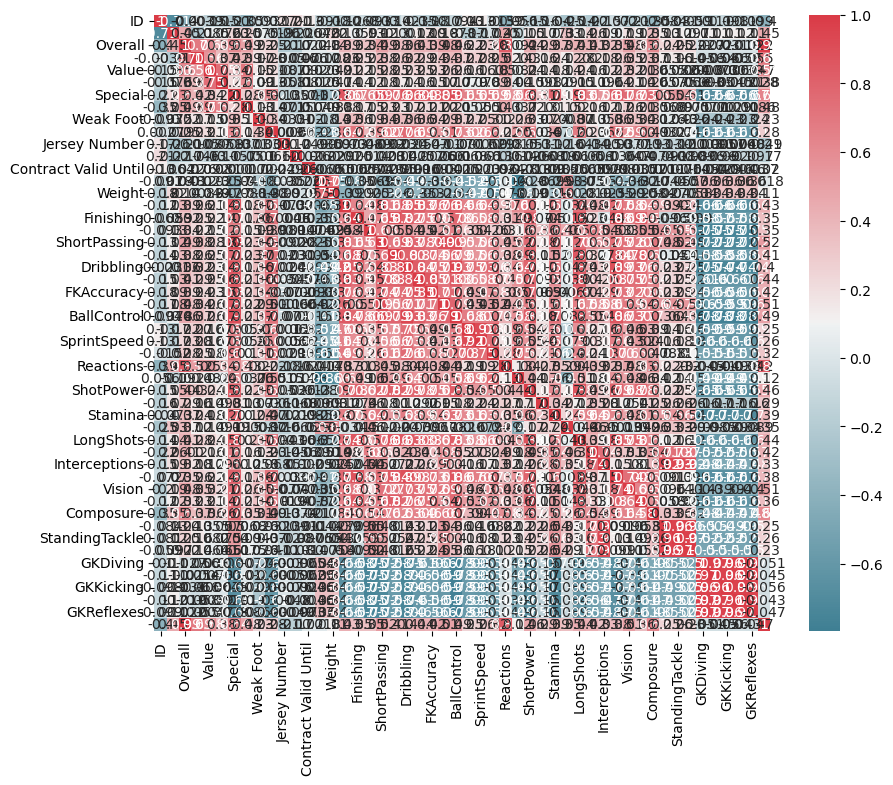

In [18]:
# run correlation matrix and plot
fig, axis = plt.subplots(figsize=(10, 8))
corr = num_df.corr()
sns.heatmap(corr, annot=True,mask=np.zeros_like(corr, dtype=bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=axis)

In [19]:
from sklearn.feature_selection import SelectKBest, f_regression

X = num_df.drop(["Overall"], axis = 1)
y = num_df["Overall"]

feature_selector = SelectKBest(f_regression, k = "all")
fit = feature_selector.fit(X,y)

p_values = pd.DataFrame(fit.pvalues_)
scores = pd.DataFrame(fit.scores_)
input_variable_names = pd.DataFrame(X.columns)
summary_stats = pd.concat([input_variable_names, p_values, scores], axis = 1)
summary_stats.columns = ["input_variable", "p_value", "f_score"]
summary_stats.sort_values(by = "p_value", inplace = True)

p_value_threshold = 0.05
score_threshold = 5

selected_variables = summary_stats.loc[(summary_stats["f_score"] >= score_threshold) &
                                       (summary_stats["p_value"] <= p_value_threshold)]
selected_variables = selected_variables["input_variable"].tolist()
X_new = X[selected_variables]
X_new

,ID,FKAccuracy,LongPassing,BallControl,Reactions,ShotPower,Jumping,Stamina,Strength,LongShots,...,Joined,Weight,Balance,Height,GKKicking,GKDiving,GKReflexes,Contract Valid Until,GKHandling,GKPositioning
0,176580,84.0,64.0,91.0,93.0,87.0,69.0,89.0,80.0,86.0,...,2014,86.18,60.0,1.83,31.0,27.0,37.0,2021,25.0,33.0
1,178518,68.0,81.0,85.0,87.0,84.0,76.0,94.0,78.0,86.0,...,2014,64.86,84.0,1.75,14.0,11.0,11.0,2021,11.0,8.0
2,181872,68.0,82.0,83.0,89.0,84.0,82.0,93.0,79.0,85.0,...,2015,74.84,77.0,1.80,4.0,4.0,4.0,2019,2.0,2.0
3,197445,83.0,80.0,83.0,84.0,83.0,82.0,87.0,69.0,83.0,...,2010,76.20,77.0,1.80,14.0,5.0,9.0,2021,7.0,15.0
4,195864,82.0,88.0,90.0,86.0,90.0,85.0,91.0,91.0,87.0,...,2016,83.91,61.0,1.91,2.0,5.0,3.0,2021,6.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17312,233215,12.0,24.0,11.0,40.0,23.0,37.0,19.0,42.0,8.0,...,2016,72.12,22.0,1.93,48.0,51.0,60.0,2018,51.0,59.0
17313,232911,8.0,18.0,11.0,57.0,24.0,38.0,20.0,68.0,6.0,...,2003,93.89,22.0,1.88,41.0,59.0,59.0,2020,46.0,62.0
17314,235387,12.0,29.0,15.0,34.0,18.0,37.0,22.0,62.0,9.0,...,2016,87.09,22.0,1.93,49.0,54.0,58.0,2019,50.0,54.0
17315,237904,10.0,15.0,14.0,44.0,17.0,32.0,18.0,57.0,5.0,...,2016,78.02,23.0,1.91,52.0,47.0,49.0,2020,59.0,44.0


In [22]:
summary_stats

,input_variable,p_value,f_score
0,ID,0.000000e+00,3.340138e+03
21,FKAccuracy,0.000000e+00,3.170858e+03
22,LongPassing,0.000000e+00,5.136724e+03
23,BallControl,0.000000e+00,4.603066e+03
27,Reactions,0.000000e+00,3.794861e+04
29,ShotPower,0.000000e+00,4.071679e+03
30,Jumping,0.000000e+00,1.588069e+03
31,Stamina,0.000000e+00,2.701704e+03
32,Strength,0.000000e+00,2.735624e+03
33,LongShots,0.000000e+00,3.574016e+03


In [23]:
from sklearn.feature_selection import RFECV 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

X = num_df.drop(["Overall"], axis = 1)
y = num_df["Overall"]

regressor = LinearRegression()
feature_selector = RFECV(regressor)

fit = feature_selector.fit(X,y)

optimal_feature_count = feature_selector.n_features_
print(f"Optimal numer of features: {optimal_feature_count}")

X_new = X.loc[:, feature_selector.get_support()]

plt.plot(range(1, len(fit.grid_scores_) + 1), fit.grid_scores_, marker = "o")
plt.ylabel("Model Score")
plt.xlabel("Number of Features")
plt.title(f"Feature Selection using RFE \n Optimal number of features is {optimal_feature_count} (at score of {round(max(fit.grid_scores_), 4)})")
plt.tight_layout() 
plt.show()

Optimal numer of features: 49


AttributeError: 'RFECV' object has no attribute 'grid_scores_'